#Installations

In [1]:
!pip install torch_geometric
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00


#Imports

In [2]:
# Tensors and neural net functions
import torch
import torch.nn.functional as F
# GNN Layers
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
# Auto-downloads citation graph datasets
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import CoraFull
import torch_geometric.transforms as T
# Math
import numpy as np
import pandas as pd
import random
from pathlib import Path
# Adejancy matrix
import networkx as nx
from sklearn.cluster import KMeans #  For clustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score # For evaluating
from __future__ import annotations
from torch_geometric.transforms import RandomNodeSplit
from typing import Dict, Hashable, Iterable, Optional, Tuple
from scipy.sparse import csr_matrix
from itertools import combinations
from scipy.sparse import coo_matrix, csr_matrix
from numpy.linalg import eigh # use in SpecF
from typing import List
# Plots
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# used to align cluster IDs with most common true labels
from scipy.stats import mode
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from collections import Counter, defaultdict
from collections import deque
from matplotlib.lines import Line2D

#GraphSAGE implementation flow

In [3]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels) # Aggregates 1-hop neighbors
        self.conv2 = SAGEConv(hidden_channels, out_channels) # Aggregates 2-hop neighbors

    def forward(self, x, edge_index):
        # first layer
        x = self.conv1(x, edge_index)
        # non linar activation
        x = F.relu(x)
        # second layer
        x = self.conv2(x, edge_index)
        # convert embeddings into probabilities
        return F.log_softmax(x, dim=1)

# Loading CoraFull & setting up training




In [4]:
# importing Cora dataset
#https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.datasets.CoraFull.html
# nodes = papers
# edges = citation links
# data.x = features
# data.y = labels
# train_mask, val_mask, test_mask splits.
dataset = CoraFull(root='data/CoraFull', transform=RandomNodeSplit(
    split='train_rest',  # common setting for node classification
    num_val=0.1,
    num_test=0.2
))
data = dataset[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# in_channels = dataset.num_features → dimension of paper feature vectors.
# hidden_channels = 64
# out_channels = dataset.num_classes (number of Cora classes).
model = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
# Create an Adam optimizer for training.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Processing...
Done!


##Train & evaluation

In [5]:
def train():
    model.train() # sets the model in training mode
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)             # log-probs [num_nodes, num_classes]

    # Uses only training nodes. Compares predicted log-probs to true labels;
    # lower loss = better classification.
    loss = F.nll_loss(out[data.train_mask],          # NLL since model returns log_softmax
                      data.y[data.train_mask])
    loss.backward()
    optimizer.step() # updates weights using gradients
    return float(loss) # return the loss

@torch.no_grad()
def test():
    model.eval()
    # Runs forward pass, takes the class with highest log-prob for each node → predicted labels.
    out = model(data.x, data.edge_index).argmax(dim=1)
    def acc(mask):
        return (out[mask] == data.y[mask]).float().mean().item()
    return acc(data.train_mask), acc(data.val_mask), acc(data.test_mask)

# Repeats training for 200 epochs
# Every 20 epochs prints current loss and train/val/test accuracies.
# This part teaches GraphSAGE model to classify Cora nodes correctly.
for epoch in range(1, 181):
    loss = train()
    if epoch % 20 == 0:
        tr, va, te = test()
        print(f"Epoch {epoch:03d} | loss {loss:.4f} | accs (train/val/test): {tr:.3f}/{va:.3f}/{te:.3f}")

/tmp/ipython-input-174768471.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss) # return the loss


Epoch 020 | loss 0.3007 | accs (train/val/test): 0.952/0.715/0.714
Epoch 040 | loss 0.1428 | accs (train/val/test): 0.997/0.714/0.716
Epoch 060 | loss 0.0995 | accs (train/val/test): 0.999/0.720/0.715
Epoch 080 | loss 0.0798 | accs (train/val/test): 0.999/0.721/0.718
Epoch 100 | loss 0.0693 | accs (train/val/test): 1.000/0.718/0.719
Epoch 120 | loss 0.0639 | accs (train/val/test): 1.000/0.720/0.719
Epoch 140 | loss 0.0637 | accs (train/val/test): 1.000/0.716/0.720
Epoch 160 | loss 0.0582 | accs (train/val/test): 1.000/0.718/0.716
Epoch 180 | loss 0.0566 | accs (train/val/test): 1.000/0.717/0.718


##Generating embeddings using GraphSAGE

In [6]:
@torch.no_grad()
def get_GraphSAGE_embeddings(model, data):
    """
    Returns:
      h1: 1-hop embeddings  [N, hidden_dim]
      h2: 2-hop embeddings  [N, out_dim]  (pre-softmax/log-softmax)
    """
    model.eval()
    h1 = F.relu(model.conv1(data.x, data.edge_index))
    h2 = model.conv2(h1, data.edge_index)  # <-- use pre-softmax as embeddings
    # Return the 2-hop structural embedding for each node
    return h2

##Clustering using K-means

In [7]:
# Converts embeddings h2 into a numpy array X
h2 = get_GraphSAGE_embeddings(model, data)
Z = h2  # tensor [N, D]
X = Z.detach().cpu().numpy()

# Sets number of clusters = number of ground truth classes in Cora (7).
k = int(torch.unique(data.y).numel())
print(k)

# Run K-means
km = KMeans(n_clusters=k, n_init=10, random_state=0)
pred_clusters = km.fit_predict(X) # Each node gets a community ID.

# evaluate clustering quality
y_true = data.y.cpu().numpy()
nmi = normalized_mutual_info_score(y_true, pred_clusters)
ari = adjusted_rand_score(y_true, pred_clusters)

# Silhouette score: intrinsic cluster separability
sil = silhouette_score(X, pred_clusters) if k > 1 else float("nan")

print(f"KMeans on 2-hop embeddings -> NMI: {nmi:.3f} | ARI: {ari:.3f} | Silhouette: {sil:.3f}")


70
KMeans on 2-hop embeddings -> NMI: 0.693 | ARI: 0.468 | Silhouette: 0.110


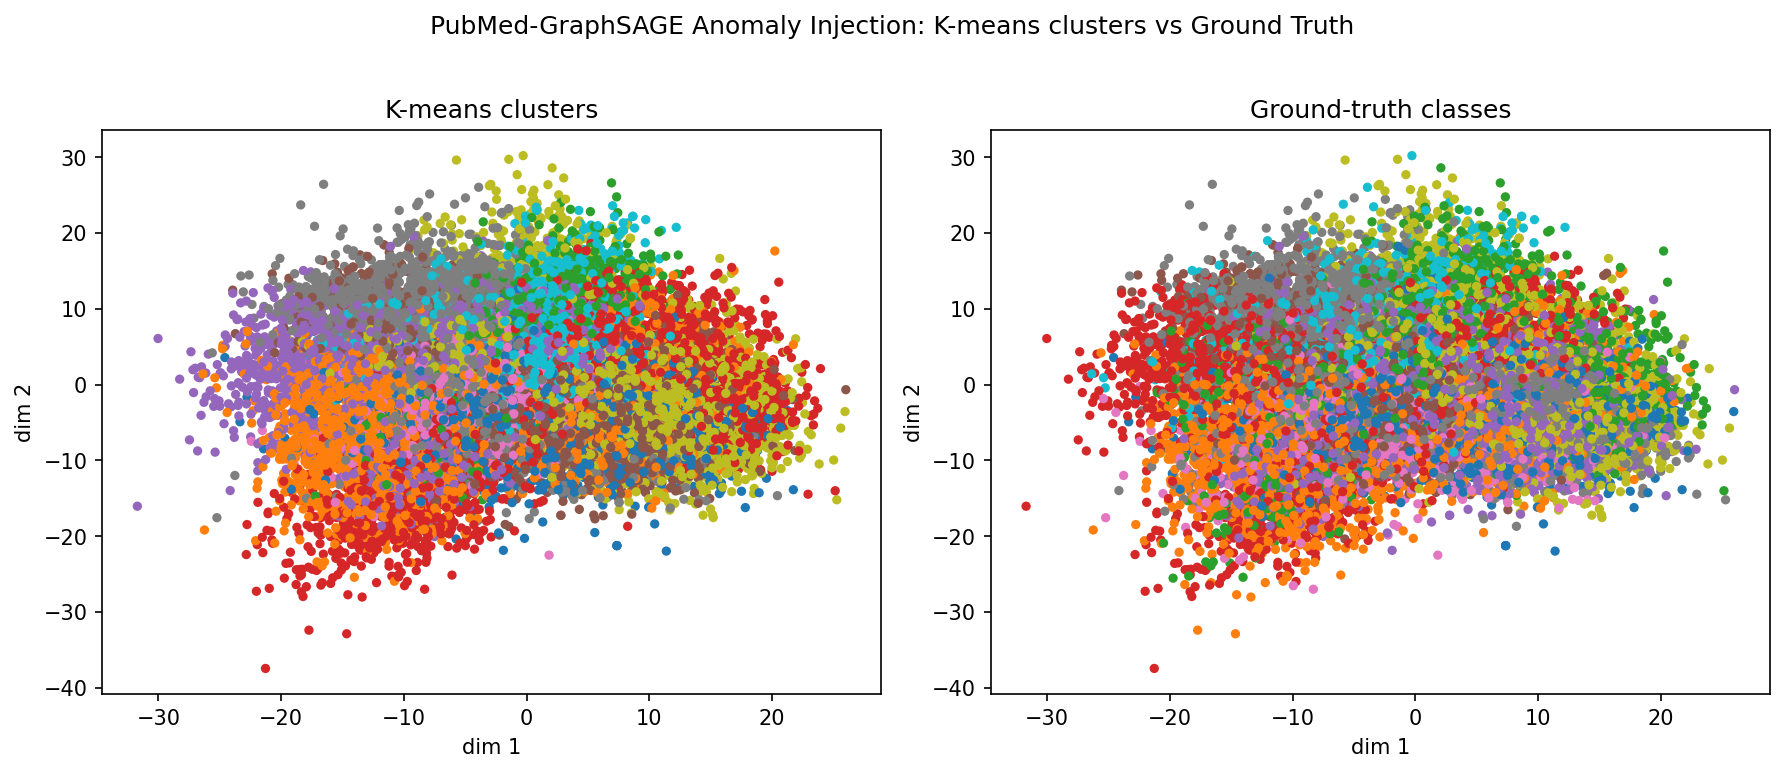

In [8]:
# --------------------------------------------------
# Align cluster IDs to dominant true labels
# --------------------------------------------------
def align_clusters_to_labels(clusters, true_labels):
    clusters_aligned = np.zeros_like(clusters)
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        most_common_label = mode(true_labels[mask], keepdims=False).mode
        clusters_aligned[mask] = most_common_label
    return clusters_aligned

clusters_aligned = align_clusters_to_labels(pred_clusters, y_true)

# --------------------------------------------------
# Reduce embeddings to 2D
# --------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# --------------------------------------------------
# One figure with two panels
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

axes[0].scatter(X2[:, 0], X2[:, 1], c=clusters_aligned, s=12, cmap="tab10")
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

axes[1].scatter(X2[:, 0], X2[:, 1], c=y_true, s=12, cmap="tab10")
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

fig.suptitle("PubMed-GraphSAGE Anomaly Injection: K-means clusters vs Ground Truth", y=1.02)
fig.tight_layout()
plt.show()


## Build Expanded Adjecancy matrix
The purpose is:
Constructs the expanded adjacency matrix W used in SpecF, encoding both: actual edges, and same-community non-edges

In [9]:
def build_expanded_adjacency(
    G: nx.Graph,
    communities: Dict[Hashable, int],
    *,
    w_edge_same: int = 5,
    w_edge_diff: int = 3,
    w_nonedge_same: int = 1,
    return_node_order: bool = False,
) -> Tuple[csr_matrix, list] | csr_matrix:
    """
    Build the expanded adjacency matrix W.

    Parameters
    ----------
    G : nx.Graph
        Undirected graph.
    communities : dict
        Mapping node -> community id (your K-means clusters).
    w_edge_same : int
        Weight if i-j are neighbors and in the same community (default 5).
    w_edge_diff : int
        Weight if i-j are neighbors in different communities (default 3).
    w_nonedge_same : int
        Weight if i-j are NOT neighbors and in the same community (default 1).
    return_node_order : bool
        If True, also returns the node order used for indexing rows/cols.

    Returns
    -------
    W : scipy.sparse.csr_matrix, shape (N, N)
        Expanded adjacency matrix.
    node_order : list (optional)
        The node order corresponding to rows/cols of W (only if return_node_order=True).
    """
    # fix node order (rows/cols)
    nodes = list(G.nodes())
    N = len(nodes)
    idx = {u: i for i, u in enumerate(nodes)}

    # neighbor sets
    nbrs = {u: set(G.neighbors(u)) for u in nodes}

    rows, cols, data = [], [], []

    # 1) Add all existing edges with weights 5 or 3
    for u, v in G.edges():
        i, j = idx[u], idx[v]
        same = (communities.get(u) == communities.get(v))
        w = w_edge_same if same else w_edge_diff
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([w, w])

    # 2) Add same-community non-edges (weight 1)
    # Group nodes by community
    comm2nodes: Dict[int, list] = {}
    for u, c in communities.items():
        comm2nodes.setdefault(c, []).append(u)

    for c, c_nodes in comm2nodes.items():
        # iterate unordered pairs inside the community
        for u, v in combinations(c_nodes, 2):
            # skip if (u,v) already an edge
            if v in nbrs[u]:
                continue
            i, j = idx[u], idx[v]
            rows.extend([i, j])
            cols.extend([j, i])
            data.extend([w_nonedge_same, w_nonedge_same])

    # Build sparse; zero diagonal by default
    W = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

    return (W, nodes) if return_node_order else W


In [10]:

def calculate_community_seeds(G, communities):
    """
    Implements Equation 11: Calculates the seed signal s_k^c for each community.
    """
    # 1. Build the Community Graph (Gc)
    Gc = nx.Graph()
    unique_comms = sorted(list(set(communities.values())))
    Gc.add_nodes_from(unique_comms)

    # Count edges between communities
    for u, v in G.edges():
        c_u = communities[u]
        c_v = communities[v]
        if c_u != c_v:
            if Gc.has_edge(c_u, c_v):
                Gc[c_u][c_v]['weight'] += 1
            else:
                Gc.add_edge(c_u, c_v, weight=1)

    # 2. Calculate Seeds (Equation 11)
    community_signals = {}
    # Sort communities by the sum of their inter-community edge weights
    sorted_comms = sorted(unique_comms, key=lambda c: sum(d['weight'] for _, _, d in Gc.edges(c, data=True)))

    for i, c in enumerate(sorted_comms):
        # sum of weights of adjacent nodes in Gc
        w_sum = sum(d['weight'] for _, _, d in Gc.edges(c, data=True))
        # Equation 11: s_i^c = sum(w_ij^c) * (i + 1)
        community_signals[c] = float(w_sum * (i + 1))

    return community_signals

## Generating Normal Signals

Its job:

Seed a signal inside each community:

- For each community c, find nodes in that community.

- Choose a seed node with maximum degree (or random among them).

- Set its signal s_i^c to the corresponding community-level value community_signal[c].

- Everything else initially 0.

Propagate that signal outward:

- Uses a kind of queue-based propagation:

  - Maintains a set of marked/unmarked nodes.

  - Repeatedly selects a node, pushes its signal to neighbors, and averages.

- The conceptual effect: values diffuse across the graph so that nodes connected within the same community tend to have similar values.

Final smoothing with weights:

- If W_expanded and node_order are provided (fast path):

  - Build a vector sx_vec of signals in the order of node_order.

  - Compute row_sums = W_expanded.sum(axis=1) (degree in expanded graph).

  - Compute numer = W_expanded.dot(sx_vec) (weighted sum of neighbors’ signals).

  - Set s_vec = numer / row_sums where degree > 0.

  - Convert back to a dict {node: s_i}.

- This is a weighted average using expanded adjacency, so the signal is smooth with respect to both edges and community structure.

In [11]:
# BUILD NETWORKX GRAPH G FROM PyG edge_index
edge_index = data.edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(zip(edge_index[0], edge_index[1]))
G.add_nodes_from(range(data.num_nodes))   # ensure isolated nodes included

def normal_signal_generator(
    G: nx.Graph,
    communities: Dict[Hashable, int],               # node -> community id
    community_signal: Dict[int, float],             # community id -> seed s_k^c
    *,
    # legacy options
    use_expanded_weights: bool = False,             # if no W_expanded is given, use 5/3 scheme
    weight_attr: str = "weight",                    # edge attr for legacy averaging
    rng: Optional[random.Random] = None,
    # NEW fast path
    W_expanded: "csr_matrix" = None,                # SciPy CSR matrix (optional)
    node_order: Optional[list] = None               # nodes ordered as W_expanded rows/cols
) -> Dict[Hashable, float]:
    """
    Algorithm 4: Normal Signal Generator (paper).
    - Seeds each community at its highest-degree node with s_k^c.
    - Propagates signals along edges with community-aware transfer t.
    - Final signal is a weighted average of propagated signals.

    Fast path:
      If W_expanded (CSR) and node_order are provided, the final averaging uses:
         s = D^{-1} W_expanded @ s_x
      where D[i] = sum_j W_expanded[i, j].
    Otherwise, falls back to the legacy (loop-based) averaging.

    Returns
    -------
    s : dict {node: s_i}  Final node signals.
    """
    if rng is None:
        rng = random.Random()

    # 1. Initialization
    # S_x will hold the intermediate propagated values
    S_x: Dict[Hashable, float] = {n: 0.0 for n in G.nodes()}
    marked = {n: True for n in G.nodes()}
    degrees = dict(G.degree())

    # Queue for BFS-like propagation
    F = deque()

    # 2. Seed Selection (Heads of Communities)
    # Identify unique communities present in the graph
    present_communities = set(communities.values())

    # Pre-group nodes by community for efficiency
    nodes_by_comm = {c: [] for c in present_communities}
    for n, c in communities.items():
        if n in G:  # Ensure node is in graph
            nodes_by_comm[c].append(n)

    # Assign seed values to the highest degree node in each community
    for c in present_communities:
        nodes = nodes_by_comm[c]
        if not nodes:
            continue

        # Sort by degree (descending) then ID to break ties deterministically
        # Note: we use str(n) for ID sorting to handle mixed types if necessary
        head = max(nodes, key=lambda n: (degrees[n], str(n)))

        # Assign the seed signal for this community
        if c in community_signal:
            S_x[head] = community_signal[c]
            marked[head] = False
            F.append(head)

    # 3. Propagation Process (The core of Algorithm 4)
    while F:
        v_i = F.popleft()
        val_i = S_x[v_i]

        # Get neighbors (sorted for determinism if needed, but omitted for speed)
        neighbors = list(G.neighbors(v_i))

        for v_j in neighbors:
            # Calculate transfer rate 't'
            # If same community: t depends on degrees
            if communities[v_i] == communities[v_j]:
                d_i = degrees[v_i]
                d_j = degrees[v_j]
                denom = d_i + d_j
                mt = (d_i / denom) if denom > 0 else 0
                t = max(0.25, mt)
            else:
                # Different community: fixed low transfer rate
                t = 0.1

            # Update neighbor value: s_j <- s_j + (s_i * t)
            S_x[v_j] += val_i * t

            # Decay source value: s_i <- s_i * 0.95
            S_x[v_i] *= 0.95
            # Update local var to reflect decay for next neighbor (optional interpretation,
            # but usually decay happens once per propagation step.
            # Sticking to the paper's "After the propagation process... reduced by 5%" implies
            # it might happen after interacting with all neighbors, but iterative implementations
            # often decay per interaction. Here we decay the source *in the dict*.)

            # Add neighbor to queue if it hasn't been a source yet
            if marked[v_j]:
                marked[v_j] = False
                F.append(v_j)

        # Update the decayed value in the main dict for v_i
        S_x[v_i] = val_i * 0.95

    # 4. Final Normalization
    # We apply the weighted average smoothing.

    # PATH A: Fast path with Precomputed W_expanded
    if W_expanded is not None:
        if node_order is None:
            raise ValueError("node_order must be provided if W_expanded is used.")

        # Create a vector aligned with node_order
        n_nodes = len(node_order)
        s_vector = np.zeros(n_nodes)

        # Map S_x dict to vector
        # Create a fast lookup for node indices
        node_to_idx = {n: i for i, n in enumerate(node_order)}

        for n, val in S_x.items():
            if n in node_to_idx:
                s_vector[node_to_idx[n]] = val

        # Perform matrix multiplication: S_smooth = D^-1 * W * S
        # Compute sum of weights (degrees) for normalization
        # W_expanded is CSR, sum(axis=1) returns a matrix (n,1), flatten to array
        weighted_sums = W_expanded.dot(s_vector)
        degree_sums = np.array(W_expanded.sum(axis=1)).flatten()

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            s_smooth_vec = weighted_sums / degree_sums
            s_smooth_vec = np.nan_to_num(s_smooth_vec)

        # Map back to dict
        return {n: float(s_smooth_vec[i]) for i, n in enumerate(node_order)}

    # PATH B: Legacy Manual Calculation
    else:
        S_final = {}
        for i in G.nodes():
            neighbors = list(G.neighbors(i))

            # If isolated, keep original value
            if not neighbors:
                S_final[i] = S_x[i]
                continue

            numerator = 0.0
            denominator = 0.0

            # Define weights based on strategy
            if use_expanded_weights:
                # "Expanded" strategy: 5 for same comm, 3 for diff comm
                # We include self-loop with weight 5 (high affinity to self/comm)

                # Self
                w_self = 5.0
                numerator += w_self * S_x[i]
                denominator += w_self

                c_i = communities[i]

                for j in neighbors:
                    if c_i == communities[j]:
                        w = 5.0
                    else:
                        w = 3.0
                    numerator += w * S_x[j]
                    denominator += w
            else:
                # Standard strategy: use edge weight attribute or 1.0
                # Self (standard usually doesn't emphasize self as heavily, using 1.0 or 0)
                # Here we strictly average neighbors + self? Or just neighbors?
                # Standard smoothing usually involves self. Let's assume weight 1 for self.
                numerator += S_x[i]
                denominator += 1.0

                for j in neighbors:
                    w = G[i][j].get(weight_attr, 1.0)
                    numerator += w * S_x[j]
                    denominator += w

            S_final[i] = numerator / denominator if denominator > 0 else 0.0

        return S_final

# 1. Map communities
clusters_dict = {i: int(c) for i, c in enumerate(pred_clusters)}

# 2. CALCULATE SEEDS (The missing step)
# This uses the inter-community edge counts to set the base intensity
Sc = calculate_community_seeds(G, clusters_dict)

# 3. Build W_expanded
W_expanded, node_order = build_expanded_adjacency(G, clusters_dict, return_node_order=True)

# 4. Propagation (Algorithm 4)
# Now Sc contains the paper-derived s_k^c values
S_normal = normal_signal_generator(
    G,
    communities=clusters_dict,
    community_signal=Sc,
    W_expanded=W_expanded,
    node_order=node_order
)

## Anomaly generation

Purpose:

- Starting from the normal signal S, creates an anomalous signal B.

- Steps:

  - Interpret AN as fraction of nodes to make anomalous.

  - Copy S into B.

  - For each community, compute the max normal signal max_S in that community.

  - Randomly select k = AN * N nodes as anomaly set P.

  - For each anomaly node vi:

    - Find its community ci, take max_S for that community.

    - Sample tax uniformly from [θ/2, θ].

    - Set B[vi] = max_S * (1 + tax), i.e., boost its signal relative to its community scale.

Result:

- B: dictionary of each node and its final anomalous signal b_i.

- P: list of the anomaly node ids.

In [12]:

def anomalous_signal_generator(
    G: nx.Graph,
    S: Dict[Hashable, float],
    communities: Dict[Hashable, int],
    AN: float,
    theta: float,
    *,
    rng: Optional[random.Random] = None,
) -> Tuple[Dict[Hashable, float], List[Hashable]]:
    """
    Algorithm 5: Anomalous Signal Generator.

    Parameters
    ----------
    G : networkx.Graph
        The graph (only nodes are used here).
    S : dict
        Normal signal per node.
    communities : dict
        Mapping node -> community id.
    AN : float
        Percentage of anomalies. Accepts 0..1 or 0..100.
    theta : float
        Anomaly intensity θ. Each chosen node gets multiplied by (1 + tax),
        where tax ~ Uniform(θ/2, θ) applied to the max S in its community.
    rng : random.Random, optional
        PRNG for reproducibility.

    Returns
    -------
    B : dict
        Anomalous signal per node.
    P : list
        The list of anomalous nodes chosen.

    Notes
    -----
    For each v_i in P:
        max <- max S among nodes in community of v_i
        tax <- Uniform(θ/2, θ)
        b_i <- max * (1 + tax)
    """
    if rng is None:
        rng = random.Random(0)

    an_frac = AN / 100.0 if AN > 1.0 else AN
    an_frac = float(np.clip(an_frac, 0.0, 1.0))

    nodes = list(G.nodes())
    n = len(nodes)
    k = max(1, int(round(an_frac * n))) if an_frac > 0 else 0

    B: Dict[Hashable, float] = dict(S)
    if k == 0:
        return B, []

    # Build community -> nodes index for fast max lookup
    comm_to_nodes = {}
    for u in nodes:
        c = communities.get(u)
        if c is not None:
            comm_to_nodes.setdefault(c, []).append(u)

    # Precompute per-community max S
    comm_to_max = {}
    for c, ns in comm_to_nodes.items():
        comm_to_max[c] = max(S[u] for u in ns) if ns else 0.0

    # Sample P: AN% distinct vertices
    P = rng.sample(nodes, k)

    # Apply anomalies
    for vi in P:
        ci = communities.get(vi)
        max_S = comm_to_max.get(ci, 0.0)
        tax = rng.uniform(theta / 2.0, theta)
        B[vi] = max_S * (1.0 + tax)

    return B, P

In [13]:
B, P = anomalous_signal_generator(
    G=G,
    S=S_normal,
    communities=clusters_dict,
    AN=10,          # 10% of nodes anomalous
    theta=0.8,      # anomaly intensity θ
    rng=random.Random(42)  # reproducible
)

print(f"Injected anomalies into {len(P)} nodes. Examples:", P[:10])

Injected anomalies into 1979 nodes. Examples: [np.int64(6693), np.int64(280), np.int64(3960), np.int64(3228), np.int64(16298), np.int64(2166), np.int64(7328), np.int64(11994), np.int64(8387), np.int64(16879)]


**visualize anomalies on the embedding**

- Color nodes by B[i],

- Circle the nodes in P.

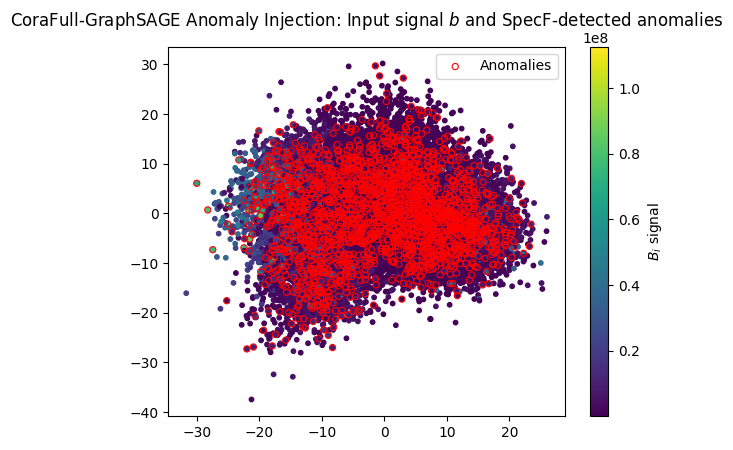

In [14]:
# convert dict to an array, assuming node ids are 0..N-1
vals_B = np.array([B[i] for i in range(len(B))])

# create anomaly mask for highlighting red circles
mask = np.zeros(len(B), dtype=bool)
mask[P] = True

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=vals_B, s=10, cmap="viridis")
plt.colorbar(label="$B_i$ signal")
plt.scatter(X2[mask,0], X2[mask,1], s=20, edgecolors="red", facecolors="none", linewidths=0.8, label="Anomalies")
plt.legend(loc="best"); plt.title("CoraFull-GraphSAGE Anomaly Injection: Input signal $b$ and SpecF-detected anomalies" , pad=15)
plt.show()

#**SpecF**

In [15]:
def specf_anomaly_detection(
    W_expanded: csr_matrix,
    B: Dict[Hashable, float],          # anomalous signal: node -> b_i
    communities: Dict[Hashable, int],  # node -> community id (from K-means)
    node_order: list,                  # order used when building W_expanded
    k: int | None = None               # how many low-frequency modes to keep
):
    """
    SpecF implementation (sparse / scalable version):

    - Build sparse Laplacian L = D - W_expanded.
    - Compute only the k smallest eigenpairs of L (low frequencies).
    - Graph Fourier transform of B using those eigenvectors.
    - Reconstruct a smoothed signal b' from low-frequency modes only.
    - Y = |B - B'| = anomaly score per node.
    - Per-community thresholding to get the anomaly set.
    """

    # 1. Build signal vector in the same order as W_expanded
    N = W_expanded.shape[0]
    assert len(node_order) == N, "node_order must match W_expanded shape"
    b_vec = np.array([B[n] for n in node_order], dtype=float)

    # 2. Build sparse Laplacian L = D - W_expanded
    deg = np.array(W_expanded.sum(axis=1)).ravel()
    D = diags(deg)                       # sparse degree matrix
    L = D - W_expanded                  # sparse Laplacian

    # 3. Decide how many eigenvectors to compute
    if k is None:
        k = len(set(communities.values()))   # use #communities if not given

    # Safety: k must be < N and at least 1
    k = max(1, min(k, N - 2))

    # 4. Compute the k smallest eigenpairs of L (low frequencies)
    # eigsh works with sparse symmetric matrices
    eigvals, U_low = eigsh(L, k=k, which="SM")   # shape U_low: (N, k)

    # (Optional) sort them by eigenvalue ascending
    order = np.argsort(eigvals)
    eigvals = eigvals[order]
    U_low = U_low[:, order]

    # 5. Graph Fourier transform of B on the low-frequency basis
    #    b_hat_low[l] = u_l^T b
    b_hat_low = U_low.T @ b_vec           # shape (k,)

    # 6. Ideal low-pass filter:
    #    since we only have the k smallest eigenvectors,
    #    using all of them is equivalent to keeping frequencies λ_0..λ_{k-1}
    #    and discarding all higher ones.
    #    -> no extra masking needed: they are already low-pass.

    # 7. Inverse transform (reconstruction from low-frequency modes)
    #    b'(i) = sum_{l=0}^{k-1} b_hat_low[l] * u_l(i)
    b_prime = U_low @ b_hat_low           # shape (N,)

    # 8. Anomaly scores Y = |B - B'|
    y_vec = np.abs(b_vec - b_prime)
    Y_scores = {n: y_vec[i] for i, n in enumerate(node_order)}  # node -> y_i

    # 9. Per-community thresholding
    anomalies = []
    comm_to_nodes: Dict[int, list] = {}
    for n in node_order:
        c = int(communities[n])
        comm_to_nodes.setdefault(c, []).append(n)

    for c, nodes_c in comm_to_nodes.items():
        vals = np.array([Y_scores[n] for n in nodes_c], dtype=float)
        if len(vals) == 0:
            continue

        mu = vals.mean()
        sigma = vals.std()

        # Threshold: mean + 2 * std within each community
        #   y_i > μ_c + 2 σ_c  ⇒ anomalous
        threshold = mu + 2.0 * sigma

        for n, y in zip(nodes_c, vals):
            if y > threshold:
                anomalies.append(n)

    return Y_scores, anomalies


In [16]:
# Calling SpecF Algorithm
k_communities = len(set(clusters_dict.values()))
print("Number of communities (k):", k_communities)

Y_scores, specf_anomalies = specf_anomaly_detection(
    W_expanded=W_expanded,
    B=B,
    communities=clusters_dict,
    node_order=node_order,
    k=k_communities
)

print(f"SpecF flagged {len(specf_anomalies)} anomalous nodes.")
print("First 10:", specf_anomalies[:10])

# Comparing SpecF detections to injected anomalies

# Convert to sets
P_set = set(P)                    # injected anomalies (ground truth)
specf_set = set(specf_anomalies)  # detected anomalies

# True/false positives/negatives
tp = len(P_set & specf_set)       # anomalies correctly found
fp = len(specf_set - P_set)       # normal nodes wrongly flagged
fn = len(P_set - specf_set)       # anomalies that SpecF missed

# Metrics
precision = tp / (tp + fp) if tp + fp > 0 else 0.0   # Of all flagged, how many are real?
recall    = tp / (tp + fn) if tp + fn > 0 else 0.0   # Of all real, how many did we catch?
f1        = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0 # harmonic mean of precision and recall.

print("\nSpecF vs injected anomalies:")
print(f"  TP={tp}, FP={fp}, FN={fn}")
print(f"  precision={precision:.3f}, recall={recall:.3f}, F1={f1:.3f}")

# Detailed lists: correctly found, missed, extra flagged

correctly_found = P_set & specf_set      # TP
missed          = P_set - specf_set      # FN
extra_flagged   = specf_set - P_set      # FP

print(f"\nTotal injected anomalies: {len(P_set)}")
print(f"Detected by SpecF:        {len(specf_set)}")
print(f"Correctly found (TP):     {len(correctly_found)}")
print(f"Missed (FN):              {len(missed)}")
print(f"Extra flagged (FP):       {len(extra_flagged)}\n")

print("Missed anomalies (node ids):", sorted(missed))
print("Extra flagged (node ids):   ", sorted(extra_flagged))

print("\nAll injected anomalies found? ->", "YES" if len(missed) == 0 else "NO")


Number of communities (k): 70
SpecF flagged 1902 anomalous nodes.
First 10: [np.int64(4682), np.int64(4611), np.int64(4624), np.int64(4577), np.int64(4743), np.int64(1045), np.int64(4884), np.int64(4774), np.int64(1418), np.int64(5077)]

SpecF vs injected anomalies:
  TP=1900, FP=2, FN=79
  precision=0.999, recall=0.960, F1=0.979

Total injected anomalies: 1979
Detected by SpecF:        1902
Correctly found (TP):     1900
Missed (FN):              79
Extra flagged (FP):       2

Missed anomalies (node ids): [np.int64(370), np.int64(579), np.int64(839), np.int64(893), np.int64(923), np.int64(1245), np.int64(1574), np.int64(3035), np.int64(3060), np.int64(3267), np.int64(3393), np.int64(3565), np.int64(4058), np.int64(4071), np.int64(4511), np.int64(4780), np.int64(4958), np.int64(5037), np.int64(5174), np.int64(5517), np.int64(6039), np.int64(6419), np.int64(6693), np.int64(6772), np.int64(6794), np.int64(6899), np.int64(6907), np.int64(6932), np.int64(6993), np.int64(7076), np.int64(71

**SpecF Anomaly Detection Results in PCA Space**

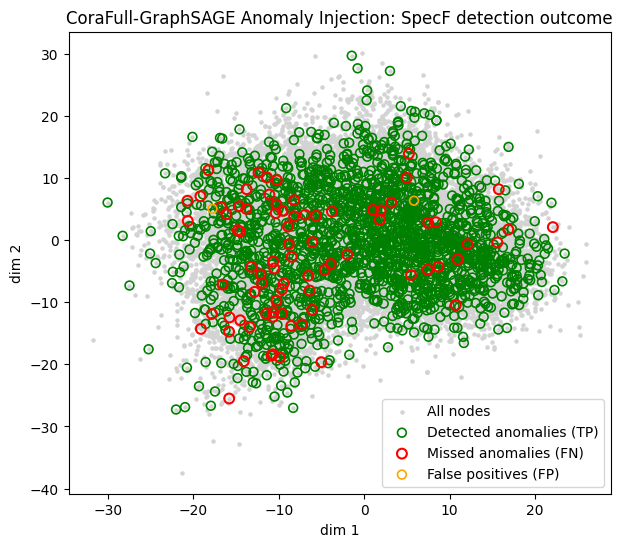

In [17]:
N = len(node_order)

# masks
mask_detected = np.zeros(N, dtype=bool)
mask_detected[list(specf_set & P_set)] = True   # TP

mask_missed = np.zeros(N, dtype=bool)
mask_missed[list(P_set - specf_set)] = True     # FN

mask_fp = np.zeros(N, dtype=bool)
mask_fp[list(specf_set - P_set)] = True         # FP

# background: all nodes
plt.figure(figsize=(7, 6))
plt.scatter(X2[:,0], X2[:,1], s=5, color="lightgray", label="All nodes")

# detected true anomalies (TP)
plt.scatter(X2[mask_detected,0], X2[mask_detected,1],
            s=40, edgecolors="green", facecolors="none",
            linewidths=1.2, label="Detected anomalies (TP)")

# missed anomalies (FN)
plt.scatter(X2[mask_missed,0], X2[mask_missed,1],
            s=50, edgecolors="red", facecolors="none",
            linewidths=1.5, label="Missed anomalies (FN)")

# false positives (FP)
plt.scatter(X2[mask_fp,0], X2[mask_fp,1],
            s=40, edgecolors="orange", facecolors="none",
            linewidths=1.2, label="False positives (FP)")

plt.legend()
plt.title("CoraFull-GraphSAGE Anomaly Injection: SpecF detection outcome")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.show()


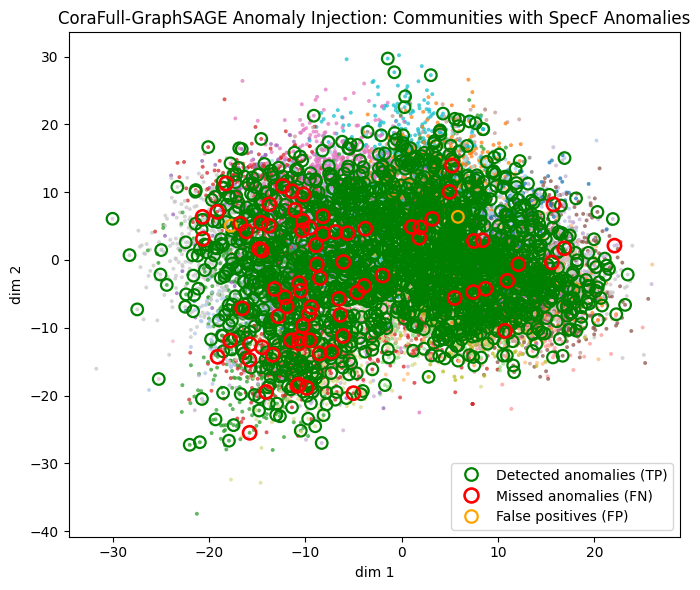

In [18]:
N = len(node_order)

# outcome masks
mask_detected = np.zeros(N, dtype=bool)  # TP
mask_detected[list(specf_set & P_set)] = True

mask_missed = np.zeros(N, dtype=bool)    # FN
mask_missed[list(P_set - specf_set)] = True

mask_fp = np.zeros(N, dtype=bool)        # FP
mask_fp[list(specf_set - P_set)] = True

# community vector aligned to node_order
# (adjust if your community labels are stored differently)
comm_vec = np.array([clusters_dict[i] for i in range(N)], dtype=int)

plt.figure(figsize=(7, 6))

# base layer: communities
sc = plt.scatter(
    X2[:, 0], X2[:, 1],
    c=comm_vec,
    s=8,
    cmap="tab20",
    alpha=0.75,
    linewidths=0,
    label="Communities"
)

# overlay: detection outcomes
plt.scatter(
    X2[mask_detected, 0], X2[mask_detected, 1],
    s=70, edgecolors="green", facecolors="none",
    linewidths=1.6, zorder=5
)

plt.scatter(
    X2[mask_missed, 0], X2[mask_missed, 1],
    s=90, edgecolors="red", facecolors="none",
    linewidths=1.9, zorder=6
)

plt.scatter(
    X2[mask_fp, 0], X2[mask_fp, 1],
    s=70, edgecolors="orange", facecolors="none",
    linewidths=1.6, zorder=5
)

# legends: one for outcomes (rings), keep communities as colors
outcome_legend = [
    Line2D([0], [0], marker='o', color='w', label='Detected anomalies (TP)',
           markerfacecolor='none', markeredgecolor='green', markersize=9, markeredgewidth=1.6),
    Line2D([0], [0], marker='o', color='w', label='Missed anomalies (FN)',
           markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=1.9),
    Line2D([0], [0], marker='o', color='w', label='False positives (FP)',
           markerfacecolor='none', markeredgecolor='orange', markersize=9, markeredgewidth=1.6),
]

plt.legend(handles=outcome_legend, loc="best", frameon=True)

plt.title("CoraFull-GraphSAGE Anomaly Injection: Communities with SpecF Anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.tight_layout()
plt.show()

**SpecF Anomaly Detection in Signal–Spectral Deviation Space**

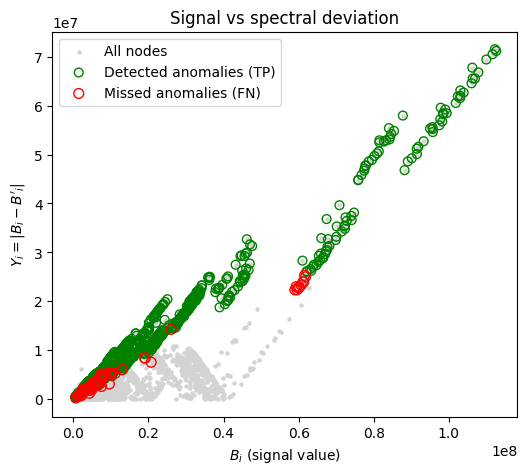

In [19]:
vals_B = np.array([B[i] for i in range(N)])
vals_Y = np.array([Y_scores[i] for i in range(N)])

plt.figure(figsize=(6,5))
plt.scatter(vals_B, vals_Y, s=5, color="lightgray", label="All nodes")

plt.scatter(vals_B[list(specf_set & P_set)],
            vals_Y[list(specf_set & P_set)],
            s=40, facecolors="none", edgecolors="green",
            label="Detected anomalies (TP)")

plt.scatter(vals_B[list(P_set - specf_set)],
            vals_Y[list(P_set - specf_set)],
            s=50, facecolors="none", edgecolors="red",
            label="Missed anomalies (FN)")

plt.xlabel(r"$B_i$ (signal value)")
plt.ylabel(r"$Y_i = |B_i - B'_i|$")
plt.title("Signal vs spectral deviation")
plt.legend()
plt.show()


**Community-wise Distribution of Injected Anomalies (Detected vs. Missed)**

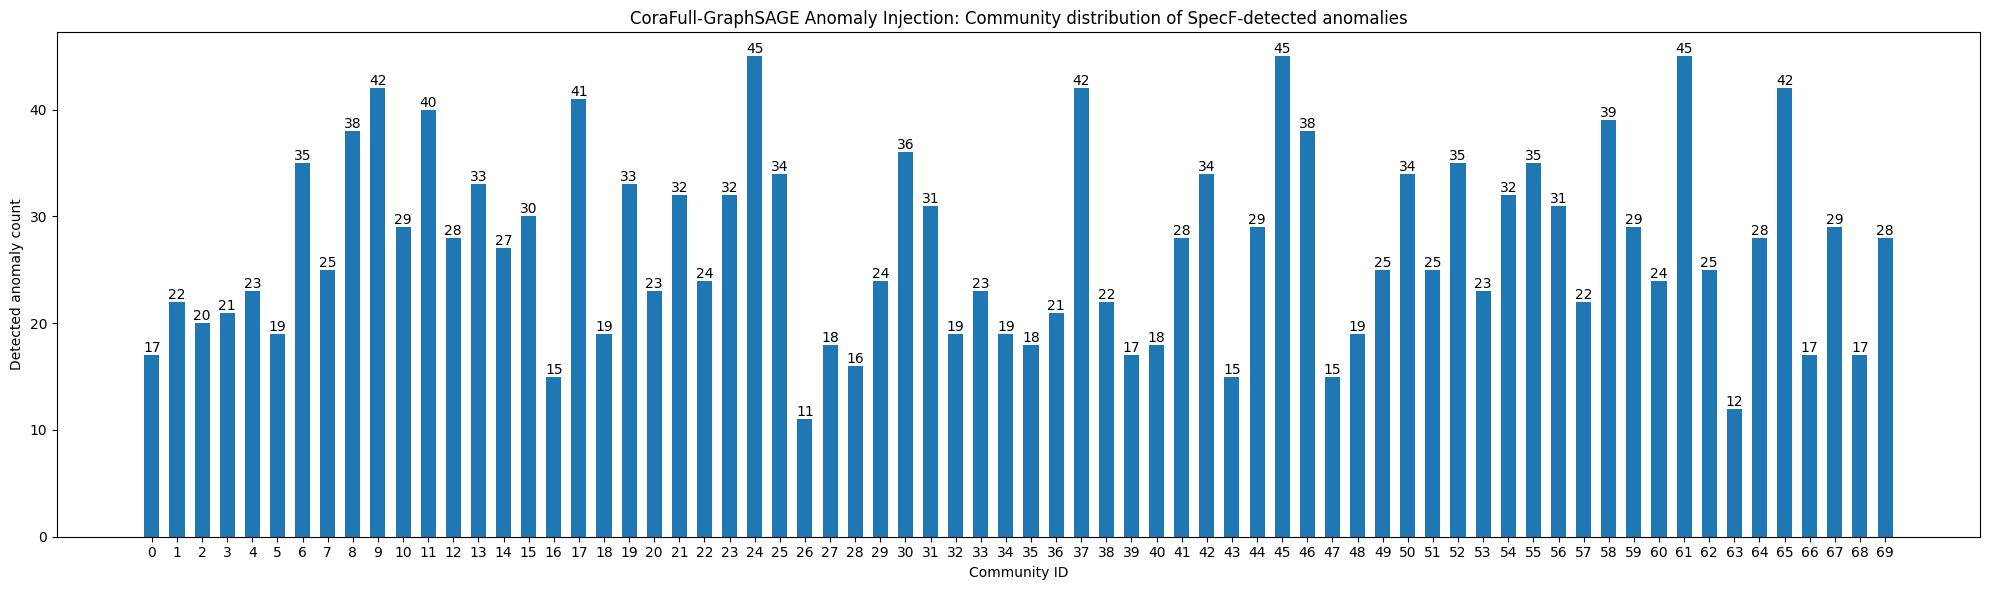

In [20]:
# Communities of SpecF-detected anomalies
detected_comms = [clusters_dict[n] for n in specf_set]
detected_cnt = Counter(detected_comms)

all_comms = sorted(detected_cnt)
x = np.arange(len(all_comms))
vals = [detected_cnt[c] for c in all_comms]

plt.figure(figsize=(20, 6))
bars = plt.bar(x, vals, width=0.6)

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks(x, all_comms)
plt.xlabel("Community ID")
plt.ylabel("Detected anomaly count")
plt.title("CoraFull-GraphSAGE Anomaly Injection: Community distribution of SpecF-detected anomalies")
plt.tight_layout()
plt.show()

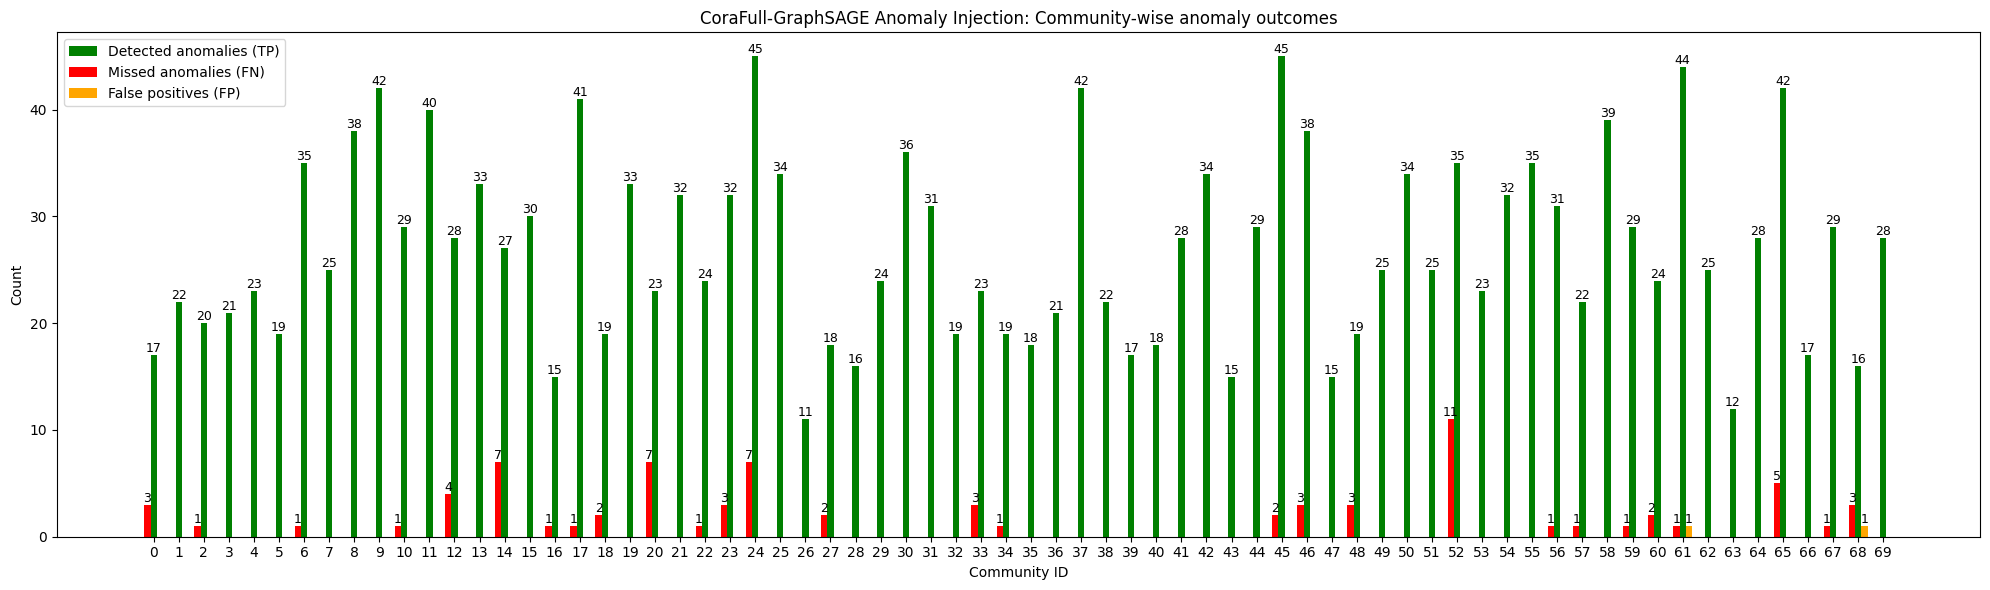

In [21]:
# community lists
missed_comms = [clusters_dict[n] for n in (P_set - specf_set)]     # FN
detected_comms = [clusters_dict[n] for n in (P_set & specf_set)]   # TP
fp_comms = [clusters_dict[n] for n in (specf_set - P_set)]         # FP

# counts per community
missed_cnt = Counter(missed_comms)
detected_cnt = Counter(detected_comms)
fp_cnt = Counter(fp_comms)

# communities
all_comms = sorted(set(missed_cnt) | set(detected_cnt) | set(fp_cnt))
x = np.arange(len(all_comms))
width = 0.25

# values
missed_vals = [missed_cnt.get(c, 0) for c in all_comms]
detected_vals = [detected_cnt.get(c, 0) for c in all_comms]
fp_vals = [fp_cnt.get(c, 0) for c in all_comms]

plt.figure(figsize=(20, 6))

bars_detected = plt.bar(
    x, detected_vals, width,
    label="Detected anomalies (TP)",
    color="green"
)

bars_missed = plt.bar(
    x - width, missed_vals, width,
    label="Missed anomalies (FN)",
    color="red"
)

bars_fp = plt.bar(
    x + width, fp_vals, width,
    label="False positives (FP)",
    color="orange"   # yellow, but readable
)

# annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{int(height)}",
                ha="center",
                va="bottom",
                fontsize=9
            )

annotate_bars(bars_missed)
annotate_bars(bars_detected)
annotate_bars(bars_fp)

# labels
plt.xticks(x, all_comms)
plt.xlabel("Community ID")
plt.ylabel("Count")
plt.title("CoraFull-GraphSAGE Anomaly Injection: Community-wise anomaly outcomes")
plt.legend()
plt.tight_layout()
plt.show()


# **SpecF Evaluation Under Anomaly Injection: Parameter Sweep over 𝜃 and 𝐴𝑁**

In [22]:
# Build a mapping from node id to its index in node_order (kept for completeness)
id_to_idx = {node_id: idx for idx, node_id in enumerate(node_order)}

for theta_val in np.arange(0.0, 0.5, 0.05):
    for an in [0.01, 0.05, 0.1, 0.15]:

        print("\n" + "="*70)
        print(f"Processing with theta = {theta_val:.2f}, AN = {an:.2f}")

        # ------------------------------------------------------------
        # Generate anomalous signals (injection experiment)
        # ------------------------------------------------------------
        B, P = anomalous_signal_generator(
            G=G,
            S=S_normal,
            communities=clusters_dict,
            AN=an,
            theta=theta_val,
            rng=random.Random(42)
        )

        num_injected = len(P)
        num_nodes = len(B)
        pct_injected = 100.0 * num_injected / num_nodes if num_nodes > 0 else 0.0

        print(f"Injected anomalies: {num_injected} / {num_nodes} "
              f"({pct_injected:.3f}%)")

        # ------------------------------------------------------------
        # SpecF detection
        # ------------------------------------------------------------
        Y_scores, specf_anomalies = specf_anomaly_detection(
            W_expanded=W_expanded,
            B=B,
            communities=clusters_dict,
            node_order=node_order,
            k=k_communities
        )

        # Sets for evaluation
        P_set = set(P)                       # injected anomalies (GT)
        specf_set = set(specf_anomalies)     # detected by SpecF

        # ------------------------------------------------------------
        # Metrics
        # ------------------------------------------------------------
        tp = len(P_set & specf_set)
        fp = len(specf_set - P_set)
        fn = len(P_set - specf_set)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = (2 * precision * recall /
                     (precision + recall)) if (precision + recall) > 0 else 0.0

        print(f"Detected anomalies: {len(specf_set)}")
        print(f"TP={tp}, FP={fp}, FN={fn}")
        print(f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

        # ------------------------------------------------------------
        # Per-community summary
        # ------------------------------------------------------------
        injected_by_comm = Counter(clusters_dict[n] for n in P_set)
        detected_by_comm = Counter(clusters_dict[n] for n in specf_set)
        missed_by_comm   = Counter(clusters_dict[n] for n in (P_set - specf_set))
        fp_by_comm       = Counter(clusters_dict[n] for n in (specf_set - P_set))

        print("\nPer-community anomaly summary")
        print("-" * 55)
        print(f"{'Comm':>6s} | {'Injected':>8s} | {'Detected':>8s} | {'Missed':>6s} | {'FP':>4s}")
        print("-" * 55)
        all_comms = sorted(
            set(injected_by_comm) |
            set(detected_by_comm) |
            set(missed_by_comm) |
            set(fp_by_comm)
        )

        for c in all_comms:
          print(f"{c:6d} | "
            f"{injected_by_comm.get(c,0):8d} | "
            f"{detected_by_comm.get(c,0):8d} | "
            f"{missed_by_comm.get(c,0):6d} | "
            f"{fp_by_comm.get(c,0):4d}")

        # ------------------------------------------------------------
        # Detailed list: missed injected anomalies (FN)
        # ------------------------------------------------------------
        if fn > 0:
            fn_nodes = sorted(P_set - specf_set)
            print("\nUndetected injected anomalies (FN)")
            print("node_id | community | B[node] | Y[node]")

            K = 50  # limit output
            for node_id in fn_nodes[:K]:
                comm = clusters_dict[node_id]
                bval = B[node_id]          # B is dict: node_id -> value
                yval = Y_scores[node_id]   # same indexing
                print(f"{node_id:6d} | "
                      f"{comm:9d} | "
                      f"{bval:8.6f} | "
                      f"{yval:8.6f}")

            if len(fn_nodes) > K:
                print(f"... and {len(fn_nodes) - K} more missed anomalies")
        else:
            print("\nAll injected anomalies were detected.")



Processing with theta = 0.00, AN = 0.01
Injected anomalies: 198 / 19793 (1.000%)
Detected anomalies: 705
TP=197, FP=508, FN=1
Precision=0.279, Recall=0.995, F1=0.436

Per-community anomaly summary
-------------------------------------------------------
  Comm | Injected | Detected | Missed |   FP
-------------------------------------------------------
     0 |        0 |        5 |      0 |    5
     1 |        1 |       11 |      0 |   10
     2 |        3 |        7 |      0 |    4
     3 |        2 |        7 |      0 |    5
     4 |        1 |       12 |      0 |   11
     5 |        3 |        6 |      0 |    3
     6 |        2 |       16 |      0 |   14
     7 |        5 |        6 |      0 |    1
     8 |        4 |        7 |      0 |    3
     9 |        1 |       12 |      0 |   11
    10 |        3 |        4 |      0 |    1
    11 |        5 |       20 |      0 |   15
    12 |        3 |        7 |      0 |    4
    13 |        3 |        8 |      0 |    5
    14 |       